In [1]:
import numpy as np 
import pandas as pd 


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from tensorflow import random as tf_random

# ignore Warning
import warnings
warnings.filterwarnings("ignore") 

Using TensorFlow backend.


In [2]:
train = pd.read_csv('files_csv/train.csv')
test = pd.read_csv('files_csv/test.csv')

In [3]:
print(f' train shape {train.shape}')
print(f' test shape {test.shape}')

 train shape (1460, 81)
 test shape (1459, 80)


### Distribution de SalePrice et Log

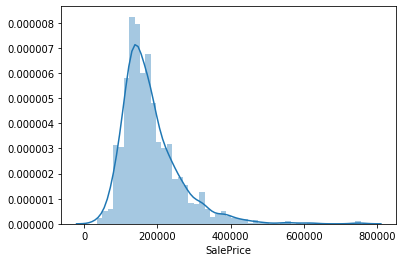

In [4]:
sns.distplot(train['SalePrice'])

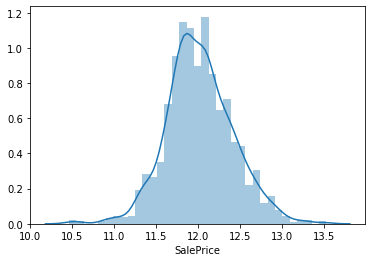

In [5]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'])

###  On garde que les features numériques de train

In [6]:
train = train.select_dtypes(exclude=['object'])
train.shape

(1460, 38)

In [7]:
train.drop('Id',axis = 1, inplace = True)
train.drop('MSSubClass',axis = 1, inplace = True) # fausse variable numérique
train.fillna(0,inplace=True) # a test par zero

In [8]:
train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,12.247699
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,12.109016
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,12.317171
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,11.849405
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,12.429220


#### Pareil pour test

In [9]:
test = test.select_dtypes(exclude=['object'])
test_ID = test.Id
test.fillna(0,inplace=True) # a test par zero 
test.drop('Id',axis = 1, inplace = True)
test.drop('MSSubClass',axis = 1, inplace = True) # fausse variable numérique


In [10]:
test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,...,506.0,0,82,0,0,144,0,0,1,2010


In [11]:
print(f"Features dans le dataset : {list(train.columns)}")

Features dans le dataset : ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


#### Features fortement corrélés avec SalePrice

In [12]:
# cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
# cols = ['SalePrice','GrLivArea','OverallCond','LotArea','OverallQual','1stFlrSF'] # Features importances XgBoost

Outliers

In [13]:
train = train.drop(train[(train['LotFrontage']>300)].index).reset_index(drop=True)
train = train.drop(train[(train['LotArea']>150000)].index).reset_index(drop=True)
train = train.drop(train[(train['BsmtFinSF1']>2000) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
train = train.drop(train[(train['WoodDeckSF']>600) & (train['SalePrice']<12)].index).reset_index(drop=True)
train = train.drop(train[(train['OpenPorchSF']>500) & (train['SalePrice']<11)].index).reset_index(drop=True)
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<12.5)].index).reset_index(drop=True)

X_train & y_train

In [14]:
target_column = 'SalePrice'
y_train_full = train[target_column].values
X_train_full = train.drop(target_column, axis=1).values
X_test = test.values

Seed

In [15]:
from numpy import random as np_random
SEED = 42
np_random.seed(SEED)

Split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

Normalize inputs

In [17]:
scaler_X = StandardScaler()
scaler_X.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

In [19]:
scaler_Y_log = StandardScaler()
scaler_Y_log.fit(y_train.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
y_train_log_scaled = scaler_Y_log.transform(y_train.reshape(-1,1))
y_val_log_scaled = scaler_Y_log.transform(y_val.reshape(-1,1))

Model

In [21]:
tf_random.set_seed(SEED)

* Doc : learning_rate: float >= 0. Initial learning rate, defaults to 1. It is recommended to leave it at the default value.
* Lolo : "Divise tout par 100" =)

In [22]:
n_input = X_train.shape[1]
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(100,input_dim=n_input, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta(learning_rate=0.01, rho=0.95))
    return model

In [23]:
# model = KerasRegressor(build_fn=create_model)
# epochs = np.array([500, 600,700])
# batches = np.array([5,10,15])
# param_grid = dict(nb_epoch=epochs, batch_size=batches)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid_result = grid.fit(X_train,y_train)

In [24]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [25]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3600      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 8,701
Trainable params: 8,701
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train_scaled, y_train_log_scaled, validation_data=(X_val_scaled,y_val_log_scaled), epochs=500, batch_size=10)

Train on 1083 samples, validate on 361 samples
Epoch 1/500
1083/1083 [==============================] - 0s 237us/step - loss: 0.9886 - val_loss: 0.8957
Epoch 2/500
1083/1083 [==============================] - 0s 143us/step - loss: 0.9746 - val_loss: 0.8837
Epoch 3/500
1083/1083 [==============================] - 0s 141us/step - loss: 0.9615 - val_loss: 0.8723
Epoch 4/500
1083/1083 [==============================] - 0s 172us/step - loss: 0.9491 - val_loss: 0.8614
Epoch 5/500
1083/1083 [==============================] - 0s 146us/step - loss: 0.9365 - val_loss: 0.8503
Epoch 6/500
1083/1083 [==============================] - 0s 139us/step - loss: 0.9237 - val_loss: 0.8386
Epoch 7/500
1083/1083 [==============================] - 0s 136us/step - loss: 0.9101 - val_loss: 0.8264
Epoch 8/500
1083/1083 [==============================] - 0s 133us/step - loss: 0.8957 - val_loss: 0.8136
Epoch 9/500
1083/1083 [==============================] - 0s 145us/step - loss: 0.8808 - val_loss: 0.8001
Epoch 10

Epoch 78/500
1083/1083 [==============================] - 0s 129us/step - loss: 0.1181 - val_loss: 0.1188
Epoch 79/500
1083/1083 [==============================] - 0s 123us/step - loss: 0.1175 - val_loss: 0.1183
Epoch 80/500
1083/1083 [==============================] - 0s 128us/step - loss: 0.1169 - val_loss: 0.1179
Epoch 81/500
1083/1083 [==============================] - 0s 132us/step - loss: 0.1163 - val_loss: 0.1175
Epoch 82/500
1083/1083 [==============================] - 0s 129us/step - loss: 0.1157 - val_loss: 0.1171
Epoch 83/500
1083/1083 [==============================] - 0s 127us/step - loss: 0.1151 - val_loss: 0.1166
Epoch 84/500
1083/1083 [==============================] - 0s 124us/step - loss: 0.1145 - val_loss: 0.1162
Epoch 85/500
1083/1083 [==============================] - 0s 115us/step - loss: 0.1140 - val_loss: 0.1158
Epoch 86/500
1083/1083 [==============================] - 0s 125us/step - loss: 0.1134 - val_loss: 0.1154
Epoch 87/500
1083/1083 [======================

Epoch 155/500
1083/1083 [==============================] - 0s 124us/step - loss: 0.0909 - val_loss: 0.0987
Epoch 156/500
1083/1083 [==============================] - 0s 142us/step - loss: 0.0907 - val_loss: 0.0985
Epoch 157/500
1083/1083 [==============================] - 0s 133us/step - loss: 0.0906 - val_loss: 0.0984
Epoch 158/500
1083/1083 [==============================] - 0s 140us/step - loss: 0.0904 - val_loss: 0.0982
Epoch 159/500
1083/1083 [==============================] - 0s 137us/step - loss: 0.0902 - val_loss: 0.0981
Epoch 160/500
1083/1083 [==============================] - 0s 135us/step - loss: 0.0901 - val_loss: 0.0980
Epoch 161/500
1083/1083 [==============================] - 0s 146us/step - loss: 0.0899 - val_loss: 0.0978
Epoch 162/500
1083/1083 [==============================] - 0s 128us/step - loss: 0.0897 - val_loss: 0.0977
Epoch 163/500
1083/1083 [==============================] - 0s 135us/step - loss: 0.0895 - val_loss: 0.0975
Epoch 164/500
1083/1083 [============

1083/1083 [==============================] - 0s 124us/step - loss: 0.0747 - val_loss: 0.0872
Epoch 308/500
1083/1083 [==============================] - 0s 125us/step - loss: 0.0746 - val_loss: 0.0872
Epoch 309/500
1083/1083 [==============================] - 0s 131us/step - loss: 0.0746 - val_loss: 0.0871
Epoch 310/500
1083/1083 [==============================] - 0s 128us/step - loss: 0.0745 - val_loss: 0.0871
Epoch 311/500
1083/1083 [==============================] - 0s 134us/step - loss: 0.0744 - val_loss: 0.0871
Epoch 312/500
1083/1083 [==============================] - 0s 128us/step - loss: 0.0744 - val_loss: 0.0870
Epoch 313/500
1083/1083 [==============================] - 0s 127us/step - loss: 0.0743 - val_loss: 0.0870
Epoch 314/500
1083/1083 [==============================] - 0s 127us/step - loss: 0.0742 - val_loss: 0.0870
Epoch 315/500
1083/1083 [==============================] - 0s 124us/step - loss: 0.0742 - val_loss: 0.0870
Epoch 316/500
1083/1083 [==========================

1083/1083 [==============================] - 0s 132us/step - loss: 0.0668 - val_loss: 0.0844
Epoch 460/500
1083/1083 [==============================] - 0s 123us/step - loss: 0.0667 - val_loss: 0.0843
Epoch 461/500
1083/1083 [==============================] - 0s 121us/step - loss: 0.0667 - val_loss: 0.0843
Epoch 462/500
1083/1083 [==============================] - 0s 125us/step - loss: 0.0666 - val_loss: 0.0843
Epoch 463/500
1083/1083 [==============================] - 0s 115us/step - loss: 0.0666 - val_loss: 0.0843
Epoch 464/500
1083/1083 [==============================] - 0s 115us/step - loss: 0.0665 - val_loss: 0.0843
Epoch 465/500
1083/1083 [==============================] - 0s 113us/step - loss: 0.0665 - val_loss: 0.0843
Epoch 466/500
1083/1083 [==============================] - 0s 112us/step - loss: 0.0665 - val_loss: 0.0843
Epoch 467/500
1083/1083 [==============================] - 0s 119us/step - loss: 0.0664 - val_loss: 0.0843
Epoch 468/500
1083/1083 [==========================

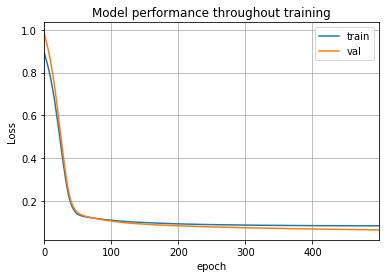

In [27]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Perfomance

### Prédiction

In [28]:
prediction_scaled = model.predict(X_test_scaled)

In [29]:
# inverse_transform
# exponentiel 

log_prediction = scaler_Y_log.inverse_transform(prediction_scaled)
prediction = np.expm1(log_prediction)
prediction 

array([[122579.14],
       [167903.05],
       [182313.8 ],
       ...,
       [168551.69],
       [112576.3 ],
       [241433.36]], dtype=float32)

In [30]:
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] =  prediction
submission.to_csv('Keras-Numfeatures.csv', index=False)